## Load data

In [28]:
import pandas as pd
import io
import boto3

def getAddress(filename):     
    return 's3://{}/{}'.format('mn-ml-1', filename)

trainingFrame = pd.read_csv(getAddress('training.csv'))
testFrame = pd.read_csv(getAddress('test.csv'))
holdoutFrame = pd.read_csv(getAddress('holdout.csv'))

## Multiple linear regression

In [1]:
import math

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error

class PyTorchLRModel(torch.nn.Module):

    def __init__(self, input_dim, output_dim):

        # call class constructor
        super(PyTorchLRModel, self).__init__()
        
        # use the nn package to create a linear layer
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):

        # Define the "forward" pass of this model. Think of this
        # for now as just the method that takes data input and
        # passes this through the model to create output (i.e., a prediction).
        out = self.linear(x)
        return out

def pytorch_lr_fit(x, y, learning_rate, epochs, lambda1, lambda2):
    """
    Train a (potentially multiple) linear regresison model 
    using SGD and pytorch.
    Args:
        x - feature array, a numpy array
        y - response array, a numpy array
        learning_rate - learning rate used in SGD
        epochs - number of epochs for the SGD loop 
        lambda1 - the l1 regularization rate
        lambda2 - the l2 regularization rate
    Returns:
        The trained model
    """

    # define the number of features that we expect as input
    # (in input_dimension), and the number of output features
    # (in output_dimension). 
    input_dimension = x.ndim
    output_dimension = y.ndim
    
    # prep the shapes of x and y for pytorch
    if input_dimension == 1:
        x = x[:, np.newaxis]
    else:
        input_dimension = x.shape[1]
    if output_dimension == 1:
        y = y[:, np.newaxis]
    else:
        output_dimension = y.shape[1]

    # initialize the model
    model = PyTorchLRModel(input_dimension, output_dimension)
    
    # our error/loss function
    criterion = torch.nn.MSELoss()
    
    # define our SGD optimizer
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda2) 

    # loop over our epochs, similar to our previous implementation
    losses = []
    for epoch in range(epochs):

        # increment the epoch count
        epoch +=1
        
        # define our feature and response variables
        features = Variable(torch.from_numpy(x).float(), requires_grad=True)
        response = Variable(torch.from_numpy(y).float())
        
        # clear the gradients
        optimiser.zero_grad()
        
        # calculate the predicted values
        predictions = model.forward(features)
        
        # calculate our loss
        loss = criterion(predictions, response)                
        
        # add l1 regularization
        if lambda1 > 0.0:
            params = torch.cat([x.view(-1) for x in model.linear.parameters()])
            l1_regularization = lambda1 * torch.norm(params, 1)
            loss += l1_regularization

        # implement our gradient-based updates to our
        # parammeters (putting them "back" into the model
        # via a "backward" update)
        loss.backward()
        optimiser.step()
        
        losses.append(loss.data.item())

    return model, losses



## Prep

In [2]:
# pick out our features and response for training
cols = ['bmi', 'map', 'ldl', 'hdl', 'tch', 'glu', 'ltg', 'y']
num_features = len(cols[0:-1])

# scale the features and response
scaler = MinMaxScaler()
train_data = scaler.fit_transform(trainingFrame[cols])

# read in and pre-process our test data
test_data = scaler.transform(testFrame[cols])

# test input for the model and observation tensors
test_input = Variable(torch.from_numpy(test_data[:, 0:num_features]).float())

NameError: name 'trainingFrame' is not defined

## Plotting loss

RMSE: 0.1669


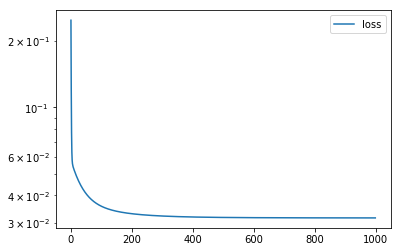

In [31]:
# fit our models
model, losses = pytorch_lr_fit(np.array(train_data[:, 0:num_features]), np.array(train_data[:, num_features]), 0.1, 1000, 0.0, 0.0)

# make our predictions by running the test input "forward"
# through the models
predictions = model(test_input)

# calculate our RMSE
rmse = math.sqrt(mean_squared_error(predictions.data.numpy(), test_data[:, num_features]))

print('RMSE: %0.4f'% rmse)

pd.DataFrame(losses, columns = ['loss']).plot(logy=True)

## L2 trend

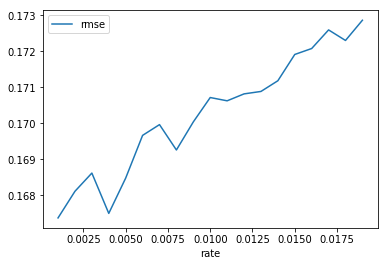

In [32]:
rmses = []
rates = np.arange(0.001, 0.02, 0.001) 
#rates = np.linspace(0.0005,0.02,100)

for l2 in rates:
    # fit our models
    model, losses = pytorch_lr_fit(np.array(train_data[:, 0:num_features]), np.array(train_data[:, num_features]), 0.1, 1000, 0, l2)

    # make our predictions by running the test input "forward"
    # through the models
    predictions = model(test_input)

    # calculate our RMSE
    rmse = math.sqrt(mean_squared_error(predictions.data.numpy(), test_data[:, num_features]))
    rmses.append(rmse)

l2Frame = pd.DataFrame({ 'rmse': rmses, 'rate': rates }, columns = ['rmse', 'rate'])
l2Frame.plot(x='rate', y='rmse')